### Permutation Importance
Permutation importance is a technique used in machine learning to assess the importance of an individual feature in a predictive model. It provides a way to understand which features have the most impact on the model's performance and can help with feature selection, interpretation, and model debugging.

The method doesn't make assumptions about the relationships between features and the target variable, making it applicable to a wide range of machine learning models. It can be a valuable tool for:
- Feature Selection
- Identifying Important Features
- ...

**Algorithm**

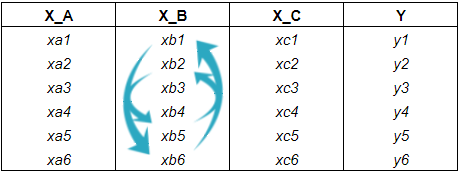

The main idea of the algorithm is to estimate a prediction change after randomly shuffling a feature. Randomly re-ordering a single feature should lead to less accurate predictions, since this feature is not going to represent any dependencies. The more important a feature, the worse a prediction is. 

**This change can be estimated on both training and test data.**

Algorithms is pretty straightforward:
1. Input parameters: fitted model `m` and `data` `D` (training or test) 
2. Compute the score/metric on data D (R2, Accuracy or F1 score)
3. Define number of shuffling `k` (e.g. 5 times randomly shuffle a feature to avoid luck)
4. For each feature `f` and shuffle `k` calculate importance as difference between normal and shuffled prediction

Obtained difference indicates how important a feature is.
- **High positive values** -> the most important features 
    - Shuffling led to significantly less accurate predictions
- **High negative values** -> the least important features
    - Shuffling led to even better predictions (it should not be the case, probably luck)

### Permutation Importance / Example
Let's build a simple baseline model and apply permutation importance method to identify useful and useless features. 

In [1]:
import eli5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from eli5.sklearn import PermutationImportance

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer, fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

from collections import defaultdict

seed = 42

In [2]:
# telecom churn data
data = pd.read_csv('data/telecom_churn.csv') # telecom churn data
data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [14]:
# select only numeric features 
numeric_features = [
    i for i in data.columns if data[i].dtype in [np.int64, np.float64]
]

X, y = data[numeric_features], data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

print('N Sampes (Train): ', X_train.shape[0])
print('N Sampes (Train): ', X_test.shape[0])

N Sampes (Train):  2499
N Sampes (Train):  834


In [15]:
model = RandomForestClassifier(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
# have a look at Permutation importance on train data
perm_imp = PermutationImportance(model, n_iter=5, random_state=seed)
perm_imp.fit(X_train, y_train)

eli5.show_weights(perm_imp, feature_names=X_train.columns.tolist())

Weight,Feature
0.0664 ± 0.0065,Customer service calls
0.0549 ± 0.0041,Total day charge
0.0520 ± 0.0047,Total day minutes
0.0294 ± 0.0025,Number vmail messages
0.0267 ± 0.0052,Total eve minutes
0.0218 ± 0.0031,Total intl charge
0.0214 ± 0.0013,Total intl calls
0.0208 ± 0.0011,Total intl minutes
0.0143 ± 0.0020,Total eve charge
0.0136 ± 0.0024,Account length


In [17]:
# output as DataFrame
pi_df = eli5.formatters.as_dataframe.explain_weights_df(
    perm_imp, 
    feature_names=X_train.columns.tolist()
)

pi_df.head()

,feature,weight,std
0,Customer service calls,0.066427,0.003271
1,Total day charge,0.054902,0.002062
2,Total day minutes,0.052021,0.002333
3,Number vmail messages,0.029372,0.001229
4,Total eve minutes,0.026731,0.002586


In [18]:
# PI per feature and per permutation 
pi_df_per_feature = pd.DataFrame(perm_imp.results_, columns=X_train.columns.tolist())
pi_df_per_feature

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,0.013205,0.001601,0.028011,0.052821,0.011605,0.052021,0.028011,0.010404,0.014406,0.010004,0.012805,0.008403,0.020008,0.021609,0.020008,0.068427
1,0.012805,0.000400,0.031613,0.051621,0.012405,0.056823,0.026811,0.009604,0.015206,0.012405,0.012805,0.010804,0.020808,0.022409,0.021609,0.067227
2,0.013205,0.001601,0.028812,0.055222,0.012005,0.056823,0.030812,0.007603,0.012405,0.010804,0.014406,0.011204,0.021208,0.021208,0.020408,0.070428
3,0.016006,0.001200,0.028812,0.048019,0.011204,0.052821,0.024410,0.008804,0.015206,0.012405,0.010804,0.008003,0.021609,0.021609,0.023209,0.065226
4,0.012805,0.002001,0.029612,0.052421,0.011204,0.056022,0.023609,0.008804,0.014406,0.012405,0.011204,0.007203,0.020408,0.020408,0.024010,0.060824


**Interpretation**
- Most of the features are important for prediction (false assumption)

**Important**

Although we have features with high change in the main metric, these features might not be relevant. **High importance might be also because of model overfitting.** Thus, it's **better to check `Permutation Importance` on test data as well.** If we notice that feature importance distribution on train is different from test data, we can identify what features are probably noise. Such features we nedd exclude, otherwise model can overfit and learn patterns that doesn't exist.

In [19]:
# PI (test data)
perm_imp.fit(X_test, y_test)
eli5.show_weights(perm_imp, feature_names=X_train.columns.tolist())

Weight,Feature
0.0458 ± 0.0078,Customer service calls
0.0422 ± 0.0139,Total day minutes
0.0400 ± 0.0039,Total day charge
0.0194 ± 0.0075,Total eve minutes
0.0173 ± 0.0062,Number vmail messages
0.0120 ± 0.0115,Total eve charge
0.0017 ± 0.0024,Total night minutes
0.0010 ± 0.0018,Account length
0.0007 ± 0.0019,Area code
-0.0000 ± 0.0043,Total night calls


**Interpretation**
- Not all features are important. Plus we have features shuffling which led to even better prediction (negative values)
- Feature importance distribution on train and test is different

In [20]:
# test performance
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.92      0.99      0.95       709
        True       0.91      0.50      0.64       125

    accuracy                           0.92       834
   macro avg       0.91      0.74      0.80       834
weighted avg       0.92      0.92      0.91       834



In [21]:
# drop useless features according to PI
features_to_drop = [
    'Total intl minutes',
    'Account length',
    'Total intl charge',
    'Area code',
    'Total eve calls'
]

features = X_train.columns[~X_train.columns.isin(features_to_drop)]
model.fit(X_train[features], y_train)

RandomForestClassifier(random_state=42)

In [22]:
perm_imp = PermutationImportance(model, random_state=seed)
perm_imp.fit(X_train[features], y_train)

eli5.show_weights(perm_imp, feature_names=X_train[features].columns.tolist())

Weight,Feature
0.0824 ± 0.0041,Total day minutes
0.0732 ± 0.0066,Customer service calls
0.0550 ± 0.0028,Total day charge
0.0417 ± 0.0064,Total eve minutes
0.0362 ± 0.0029,Number vmail messages
0.0359 ± 0.0038,Total eve charge
0.0313 ± 0.0033,Total intl calls
0.0258 ± 0.0015,Total night calls
0.0215 ± 0.0020,Total day calls
0.0209 ± 0.0056,Total night charge


In [23]:
# PI (test data)
perm_imp.fit(X_test[features], y_test)
eli5.show_weights(perm_imp, feature_names=X_test[features].columns.tolist())

Weight,Feature
0.0576 ± 0.0097,Total day minutes
0.0508 ± 0.0127,Customer service calls
0.0393 ± 0.0056,Total day charge
0.0223 ± 0.0047,Total eve minutes
0.0175 ± 0.0058,Total eve charge
0.0168 ± 0.0071,Number vmail messages
0.0012 ± 0.0053,Total night minutes
0.0002 ± 0.0061,Total night charge
-0.0024 ± 0.0026,Total night calls
-0.0029 ± 0.0019,Total day calls


In [24]:
# test performance (after feature selection)
y_pred = model.predict(X_test[features])
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.93      0.99      0.96       709
        True       0.92      0.55      0.69       125

    accuracy                           0.93       834
   macro avg       0.92      0.77      0.82       834
weighted avg       0.93      0.93      0.92       834



**Final Comparison**

We can observe that with Permutation Importance we identified less important features (noisy) in the data and eliminating them **reduced the performance on train data but boosted test performance.**

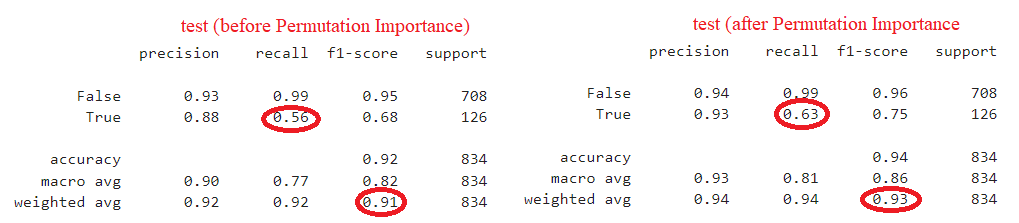

**However** we didn't check features multicollinearity that affects the `PI Value`

### Multicollinearity Effect on Feature Importance?
In case of **high correlation between features** may negatively affect on feature importance of those features. When one of those features is permuted, the model will **still have access to the feature through its correlated feature.** This will result in a **lower importance value for both features, where they might actually be important!**

**Issue**
- Because of multicollinear features, `Permutation Importance` shows that **none of the features are important, in contradiction with the high test accuracy.**

In [25]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

model = RandomForestClassifier(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)
print(f"Baseline accuracy on test data: {model.score(X_test, y_test):.2}")

Baseline accuracy on test data: 0.97


In [26]:
# check multicollinearity (some part of features)
corr_df_train = X_train.corr()
corr_df_train.iloc[:5, :5].style.background_gradient(cmap='coolwarm')

,mean radius,mean texture,mean perimeter,mean area,mean smoothness
mean radius,1.000000,0.304985,0.997859,0.986400,0.171873
mean texture,0.304985,1.000000,0.311127,0.298170,0.005450
mean perimeter,0.997859,0.311127,1.000000,0.986012,0.208890
mean area,0.986400,0.298170,0.986012,1.000000,0.180526
mean smoothness,0.171873,0.005450,0.208890,0.180526,1.000000


In [27]:
# get correlated features
thresh = 0.8
corr_matrix = corr_df_train.corr()
corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j]) >= thresh:
            col_name = corr_matrix.columns[i]
            corr_features.add(col_name)
print('Original Number of Features: ', corr_df_train.shape[1])
print('Number of Higly Correlated Features: ', len(corr_features))

Original Number of Features:  30
Number of Higly Correlated Features:  20


In [28]:
perm_imp = PermutationImportance(model, n_iter=10, random_state=seed)
perm_imp.fit(X_train, y_train)

pi_df = pd.DataFrame(perm_imp.results_, columns=X_train.columns.tolist())
pi_df_sorted = pi_df.median().sort_values(ascending=False)

- Plot the tree based feature importance (MDI) and the permutation importance. The permutation importance is calculated on the training set to show **how much the model relies on each feature during training.**

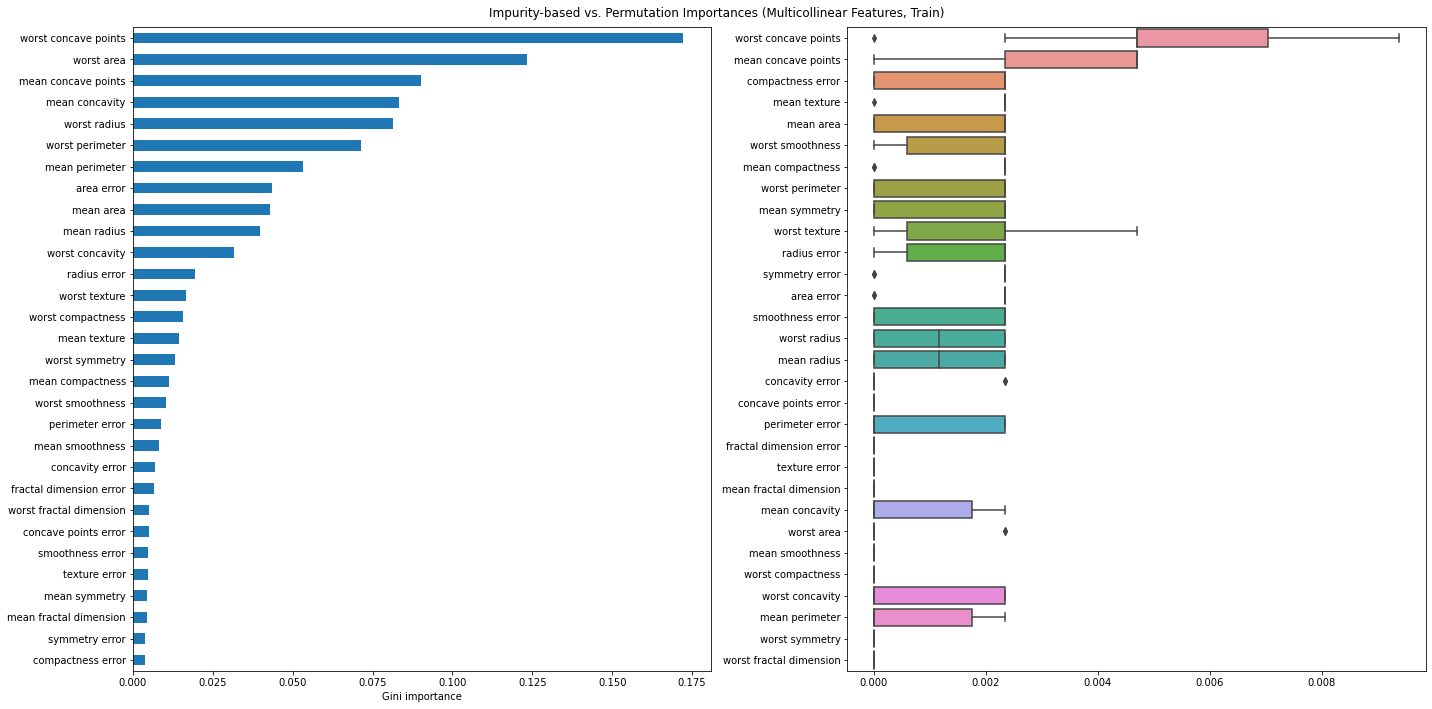

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# plot tree FI (MDI) per feature
mdi_importances = pd.Series(model.feature_importances_, index=X_train.columns)
mdi_importances.sort_values().plot.barh(ax=ax1)
ax1.set_xlabel("Gini importance");

# plot PI per feature
sns.boxplot(
    data=pi_df,
    orient='h',
    order=pi_df_sorted.index.tolist()
)

fig.suptitle("Impurity-based vs. Permutation Importances (Multicollinear Features, Train)")
_ = fig.tight_layout();

**Gini Importance**

Sklearn `RandomForest` implementation uses always subset if `sqrt(n_features)` at each split and **it's able to dilute the dominance of any correlated feature** Thus, individual feature importance may be distributed more evenly among correlated features. Since the classifier is not overfitted and we use features with that have high cardinality.

**Permutation Importance**

The permutation importance on the right plot shows that **permuting a feature drops the accuracy by at most `0.012`**, which **would suggest that none of the features are important (lead to tiny accuracy drop).** However, it contradicts what we see in the data, **model performance on test data is good.** Thus, some feature must be important.

In [30]:
# look at PI for test data
perm_imp = PermutationImportance(model, n_iter=10, random_state=seed)
perm_imp.fit(X_test, y_test)

pi_df_test = pd.DataFrame(perm_imp.results_, columns=X_test.columns.tolist())
pi_df_sorted_test = pi_df_test.median().sort_values(ascending=False)

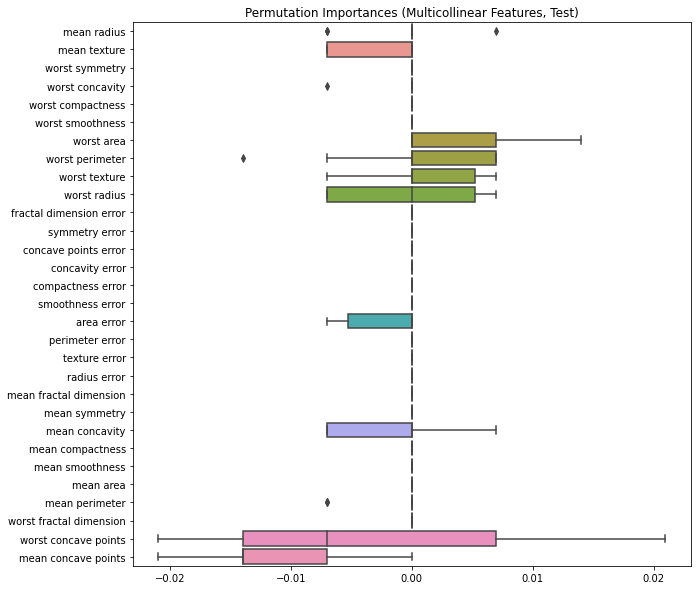

In [31]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=pi_df_test,
    orient='h',
    order=pi_df_sorted_test.index.tolist()
)
plt.title('Permutation Importances (Multicollinear Features, Test)');

Nevertheless, we see taht on test data we do have important features.

### What to do with Multicollinear Features?
When features are collinear, permuting one features results in little effect on model performance because it can get the same information from a correlated feature. 

**Solution A "Hierarchical Clustering on Sperman Rank-Order Correlation"**
- Why using Spearman Correlation?
    - Assume **monotomic dependency instead of linear** (whether the relationship is consistently increasing or decreasing between the ranks of data points)
    - Robust to outliers

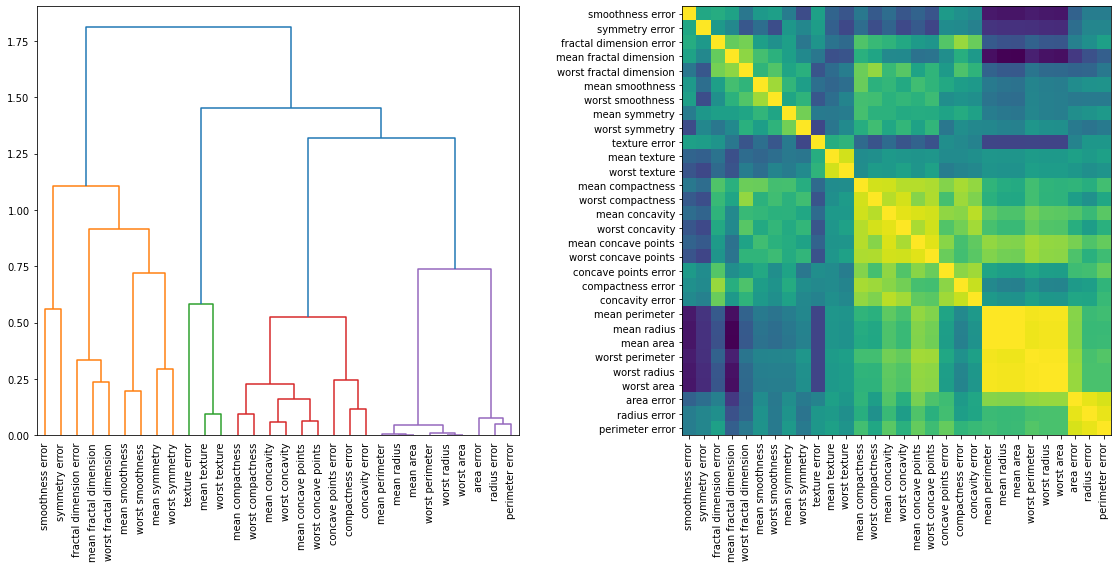

In [32]:
# 1. step: plot a heatmap of correlated features
def plot_features_corr_heatmap(
    X, figsize=(12, 8), return_dist_linkage=True
):
    """
    Plot features correlation heatmap using hierarchical clustering.
    
    Parameters
    ----------
    X: pd.DataFrame
        Matrix of features (train or test).
    figsize: tuple
        Figure size.
    return_dist_linkage: bool
        If the distances should be returned.
    
    Returns
    -------
    None or np.ndarray
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    corr = spearmanr(X).correlation
    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # convert the correlation matrix to a distance matrix
    distance_matrix = 1 - np.abs(corr)
    # perform hierarchical clustering using Ward's linkage
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
        dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
    )
    dendro_idx = np.arange(0, len(dendro["ivl"]))

    ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    ax2.set_xticks(dendro_idx)
    ax2.set_yticks(dendro_idx)
    ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
    ax2.set_yticklabels(dendro["ivl"])
    _ = fig.tight_layout()
    return dist_linkage
    
dist_linkage = plot_features_corr_heatmap(
    X_train,
    figsize=(16, 8),
    return_dist_linkage=True
)

Next, we **manually pick a threshold by visual inspection of the dendrogram to group our features into clusters and choose a feature from each cluster to keep.** Select those features from clusters and train a new model.

In [33]:
# 2 step: select features from cluster
def select_features_from_dendogram(X, dist_linkage, threshold=1):
    """
    Select features from hierarchical clustering using a threshold.
    
    Parameters
    ----------
    X: pd.DataFrame
        Matrix of features.
    dist_linkage: np.ndarray
        Features distances
    threshold: int
        Threshold for selecting number of clusters.

    Returns
    -------
    np.ndarray
        Features from the clusters.
    """
    cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    selected_features_names = X.columns[selected_features]
    return selected_features_names

selected_features = select_features_from_dendogram(X_train, dist_linkage, threshold=1.25)
print('Selected Features: ', list(selected_features))

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train[selected_features], y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {model.score(X_test[selected_features], y_test):.2}"
)

Selected Features:  ['mean radius', 'mean texture', 'mean smoothness', 'mean compactness']
Baseline accuracy on test data with features removed: 0.97


In [34]:
# check correlation one more time 
X_train[selected_features].corr().style.background_gradient(cmap='coolwarm')

,mean radius,mean texture,mean smoothness,mean compactness
mean radius,1.000000,0.304985,0.171873,0.471868
mean texture,0.304985,1.000000,0.005450,0.231029
mean smoothness,0.171873,0.005450,1.000000,0.679398
mean compactness,0.471868,0.231029,0.679398,1.000000


In [35]:
# 3 step: test Permutation Importance on selected features
perm_imp = PermutationImportance(model, n_iter=10, random_state=seed)
perm_imp.fit(X_test[selected_features], y_test)

pi_df_test = pd.DataFrame(perm_imp.results_, columns=X_test[selected_features].columns.tolist())
pi_df_test_sorted = pi_df_test.median().sort_values(ascending=False)

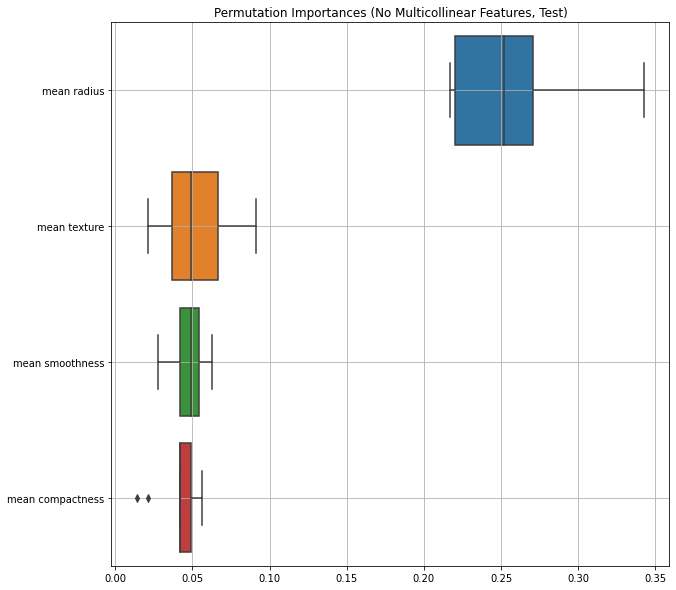

In [36]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=pi_df_test,
    orient='h',
    order=pi_df_test_sorted.index.tolist()
)
plt.title('Permutation Importances (No Multicollinear Features, Test)')
plt.grid(True);

- We see that the **selected features are all important.** Permuting them lead to drop in performance.

### Permutation Importance vs Random Forest Feature Importance (MDI)
Unfortunately, **impurity-based feature importance (MDI) can inflate the importance of numerical features.**

MDI feature importance can be misleading, since tree-based models can easily overfit the training data. Thus, useless features may become significantly important during model training (MDI is computed based on statistics from the training data).

For demonstration purposes, use the Titanic dataset and additionally create two features:
- `random_num`: high cardinality numerical feature (as many unique values as records).
- `random_cat`: a low cardinality categorical variable (3 possible values).

In [38]:
# get the data
X, y = fetch_openml(
    "titanic", version=1, as_frame=True, return_X_y=True
)

rng = np.random.RandomState(seed=seed)
X["random_cat"] = rng.randint(3, size=X.shape[0])
X["random_num"] = rng.randn(X.shape[0])

categorical_columns = ["pclass", "embarked", "random_cat", "sex"]
numerical_columns = ["age", "sibsp", "parch", "fare", "random_num"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)

In [39]:
# preprocessing steps
categorical_pipe = Pipeline([
    ('cat_imputing', SimpleImputer(strategy='most_frequent')),
    ('cat_encoding', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

numeric_pipe = Pipeline([
    ('numeric_imputing', SimpleImputer(strategy='median'))
])

# combine transformations
transformations = [
    ('categorical_preprocessing', categorical_pipe, categorical_columns),
    ('numeric_preprocessing', numeric_pipe, numeric_columns)
]

preprocessing_pipeline = ColumnTransformer(transformers=transformations)

In [40]:
main_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', RandomForestClassifier(random_state=42))
])

In [41]:
main_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('cat_imputing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoding',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['pclass', 'embarked',
                                                   'random_cat', 'sex']),
                                                 ('numeric_preprocessing',
                                                  Pipeline(steps=[('numeric_imputing',
                                                                   SimpleImputer(

### Always Check Model Performance
Before checking feature importances, it's important to know if the model has a good quality. There would be no interest of inspecting feature importances of a non-predictive model.

In [42]:
print(f"RF Train Accuracy: {main_pipeline.score(X_train, y_train):.3f}")
print(f"RF Test Accuracy: {main_pipeline.score(X_test, y_test):.3f}")

RF Train Accuracy: 1.000
RF Test Accuracy: 0.820


We observe high train accuracy (the model completely memorized the training data, however it still can generalize well on test data -> thanks baggging). We can improve test performance by adding more regularization (e.g. increase `min_samples_leaf`, set it to 5/10). **It will reduce overfitting** while not introducing too much underfitting.

**Let's keep high train accuracy to see the issue with feature importance** for features with many unique values.

### Tree's Feature Importance from Mean Decrease in Impurity (MDI)
First of all, let's have a look at the `MDI Feature Importance`

In [43]:
f_names = categorical_columns + numeric_columns

mdi_importances = pd.Series(
    main_pipeline[-1].feature_importances_,
    index=f_names
).sort_values(ascending=True)

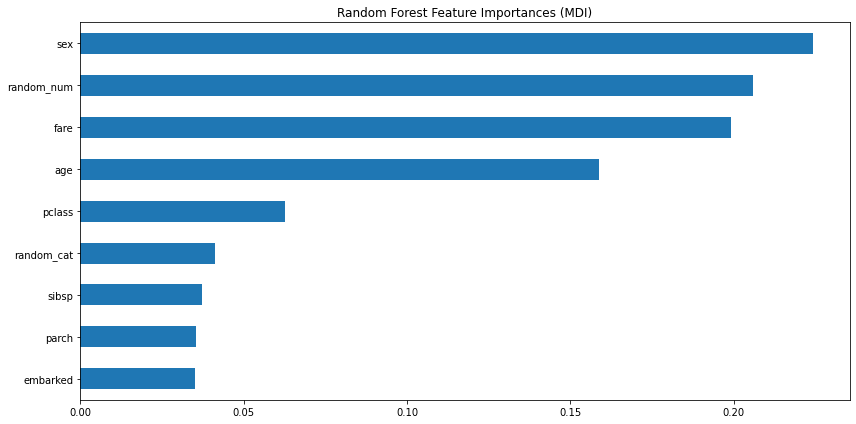

In [44]:
plt.figure(figsize=(12,6))
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

We see that our randomly created features are useful and located at the top! However, it should not be the case. The plot fools us and gives false direction. The issue is that `MDI` is limited and has the following issues:
- Impurity-based importance is **biased towards high cardinality features**
- `MDI` is **calculated on training data** and don't reflect the ability of a feature to be useful in test data

The bias towards high cardinality features explains why the `random_num` has a really large importance in comparison with `random_cat` while we would expect both random features to have a null importance. Since we are using the importance of this features from `train data` explains why `random_cat` and `random_num` have non-null importance.

**Important**
Plotting `Permutation Importance` on train and test data can give a hint if there is an overfitting. Features that are likely to be useful and lead to overfitting will have a higher Permutation Importance weight on train data and a lower or almost zero weight on test data.  

In [69]:
from sklearn.inspection import permutation_importance

pi_train = permutation_importance(
    main_pipeline,
    X_train, y_train,
    n_repeats=10,
    random_state=seed,
    n_jobs=-1
)

sorted_importances_idx = pi_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    pi_train.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)


pi_test = permutation_importance(
    main_pipeline,
    X_test, y_test,
    n_repeats=10,
    random_state=seed,
    n_jobs=-1
)

sorted_importances_idx = pi_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    pi_test.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

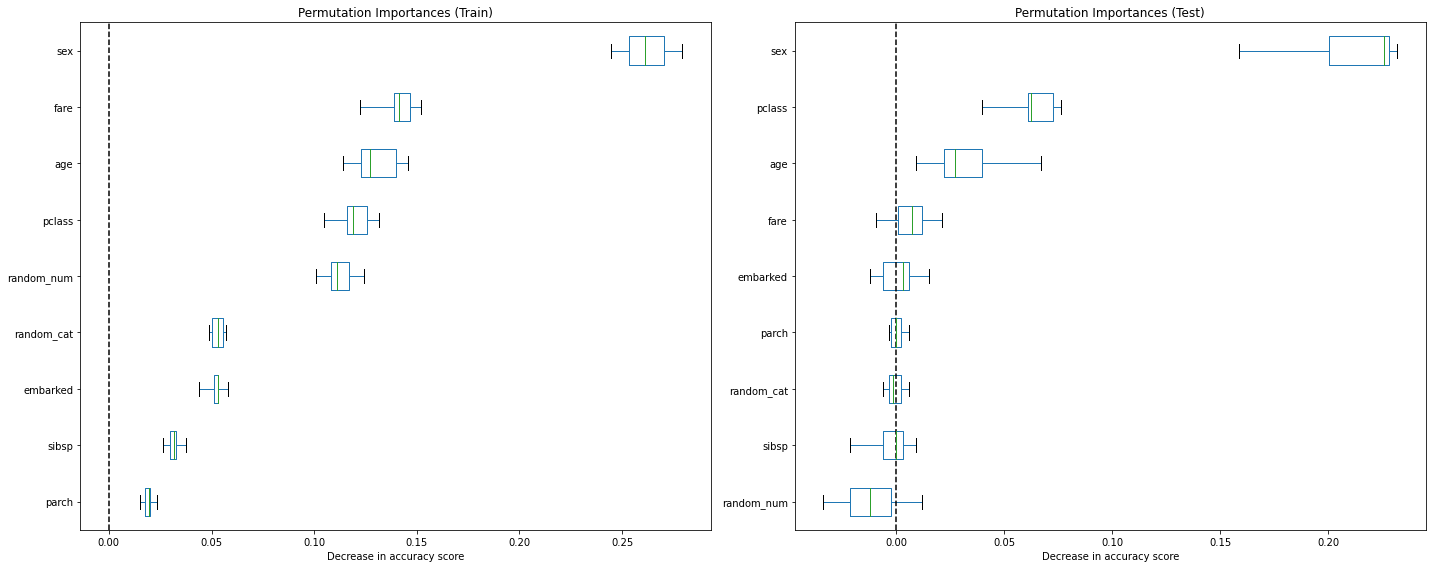

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1 = importances_train.plot.box(vert=False, whis=10, ax=ax1)
ax1.set_title("Permutation Importances (Train)")
ax1.axvline(x=0, color="k", linestyle="--")
ax1.set_xlabel("Decrease in accuracy score")
ax1.figure.tight_layout()

ax2 = importances_test.plot.box(vert=False, whis=10, ax=ax2)
ax2.set_title("Permutation Importances (Test)")
ax2.axvline(x=0, color="k", linestyle="--")
ax2.set_xlabel("Decrease in accuracy score")
ax2.figure.tight_layout()

This reveals that `random_num` and `random_cat` get a significantly higher importance ranking than when computed on the `test data`. The difference between those two plots is a **confirmation that the model** has enough capacity to use those random numerical and categorical features **to overfit.**

### Regularization Effect on MDI
We can run the experiment again, but this time we will apply regularization to the `Random Forest` model and see how this will affect the performance and `Permutation Importance`

In [71]:
# refit our pipeline but htis time using more regularized Random Forest (make the leafs less pure)
main_pipeline.set_params(model__min_samples_leaf=20).fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('cat_imputing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoding',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['pclass', 'embarked',
                                                   'random_cat', 'sex']),
                                                 ('numeric_preprocessing',
                                                  Pipeline(steps=[('numeric_imputing',
                                                                   SimpleImputer(

In [72]:
print(f"RF Train Accuracy: {main_pipeline.score(X_train, y_train):.3f}")
print(f"RF Test Accuracy: {main_pipeline.score(X_test, y_test):.3f}")

RF Train Accuracy: 0.807
RF Test Accuracy: 0.814


Now, the accuracy of both train and test data is almost the same. Thus, the model is probably not overfitting anymore. To validate this, again look at the `Permutation Importance` on train and test data

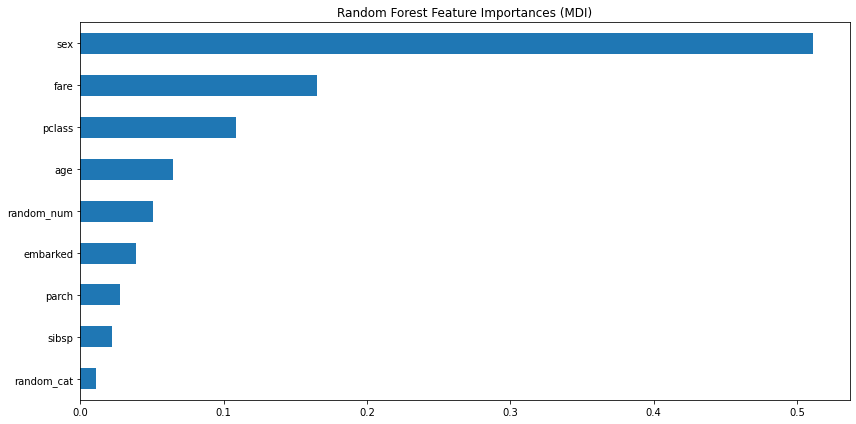

In [73]:
mdi_importances = pd.Series(
    main_pipeline[-1].feature_importances_,
    index=f_names
).sort_values(ascending=True)


plt.figure(figsize=(12,6))
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

- Indeed, it helped (`random_cat` is least important feature, however `random_num` is still important)

In [74]:
pi_train = permutation_importance(
    main_pipeline,
    X_train, y_train,
    n_repeats=10,
    random_state=seed,
    n_jobs=-1
)

sorted_importances_idx = pi_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    pi_train.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)


pi_test = permutation_importance(
    main_pipeline,
    X_test, y_test,
    n_repeats=10,
    random_state=seed,
    n_jobs=-1
)

sorted_importances_idx = pi_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    pi_test.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

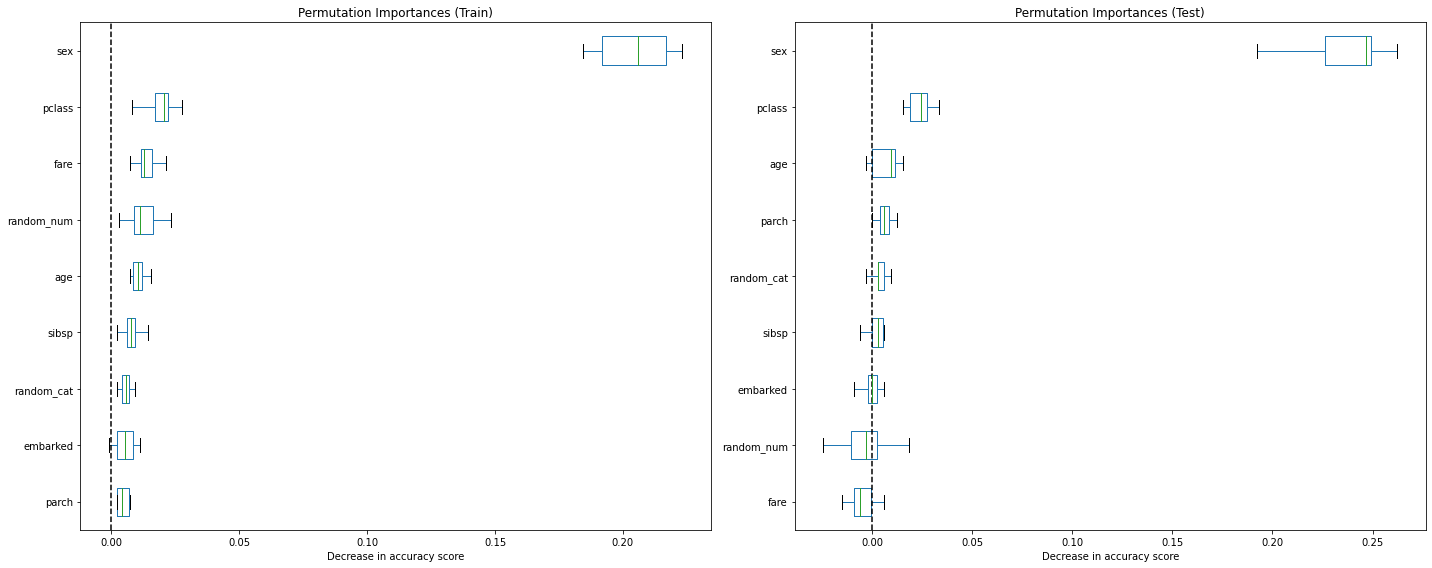

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1 = importances_train.plot.box(vert=False, whis=10, ax=ax1)
ax1.set_title("Permutation Importances (Train)")
ax1.axvline(x=0, color="k", linestyle="--")
ax1.set_xlabel("Decrease in accuracy score")
ax1.figure.tight_layout()

ax2 = importances_test.plot.box(vert=False, whis=10, ax=ax2)
ax2.set_title("Permutation Importances (Test)")
ax2.axvline(x=0, color="k", linestyle="--")
ax2.set_xlabel("Decrease in accuracy score")
ax2.figure.tight_layout()

### Always Keep in Mind 
- If possible, try to identify usefull features before applying any feature importance method. **Common sense is always the best feature selector.**
- **Permutation Importance** is insensitive to scaling, but scaling may influence the using algorithm!
- Feature importance **depends on model performance.** Thus, features with low importance in a bad model may have high importance in a good model. Thus, always validate model performance and keep it in mind when dealing with FI
- Feature Importance Distribution on **train must conside with test.** If this is not the case, there is overfitting.
Better use Permutation Importance for Tree models, because classic feature importance in tree models is based on MDI (Mean Decrease in Impurity)
    - **MDI Importance is strongly biased** and favour for high cardinality features (especially numeric), less biased to low cardinality features (binary and categorical with a small number of categories)

### Info
- https://scikit-learn.org/stable/modules/permutation_importance.html
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py (Permutation Importance vs MDI Importance)